# Belief Propagation Message Passing Visualization

This notebook provides a step-by-step visualization of the belief propagation algorithm, showing how messages are passed between nodes in a factor graph. You can see which cells are "picked" during each step and how the summation works.


In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import networkx as nx
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.patches as mpatches

# Import from the belief propagation simulator
from base_all.agents import VariableAgent, FactorAgent
from bp_base.factor_graph import FactorGraph
from base_all.bp_engine_base import BPEngine
from bp_base.bp_computators import MinSumComputator
from utils.fg_utils import generate_random_cost


NetworkX version: 3.4.2
Attempting to load: C:\Users\Public\projects\Belief_propagation_simulator_\configs\factor_graphs\factor-graph-cycle-3-random_intlow1,high100-number5.pkl
File does not exist: C:\Users\Public\projects\Belief_propagation_simulator_\configs\factor_graphs\factor-graph-cycle-3-random_intlow1,high100-number5.pkl
Available factor graph files in C:\Users\Public\projects\Belief_propagation_simulator_\configs\factor_graphs:
  - factor-graph-cycle-3-random_intlow100,high2000.3-number0.pkl
Using first available file: C:\Users\Public\projects\Belief_propagation_simulator_\configs\factor_graphs\factor-graph-cycle-3-random_intlow100,high2000.3-number0.pkl
Graph loaded. Type: <class 'bp_base.factor_graph.FactorGraph'>

Factor graph details:
Variables: 3
Factors: 3
Graph nodes: 6
Graph edges: 6

First few nodes:
  - X1
  - X2
  - X3
  - F12
  - F23

First variable: x1, Domain: 3

First factor: f12
Cost table shape: (3, 3)

Repaired graph saved to: C:\Users\Public\projects\Belief_

## 1. Create a Simple Factor Graph

We'll create a simple factor graph with a few variables and factors to demonstrate the message passing algorithm.


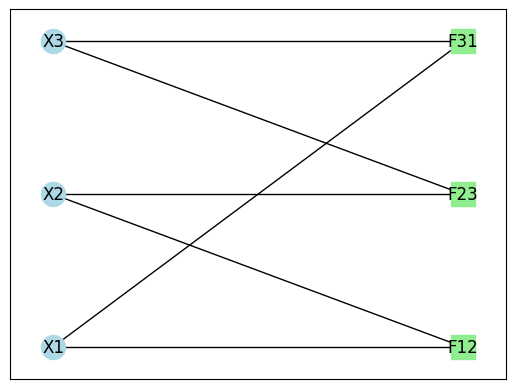

In [2]:
from utils.examples import create_simple_factor_graph_cycle
factor_graph = create_simple_factor_graph_cycle()
# Visualize the factor graph
factor_graph.visualize()


## 2. Custom BP Engine for Step-by-Step Visualization

We'll create a custom BP engine that allows us to step through the algorithm and visualize each step.


In [3]:
class VisualizationBPEngine(BPEngine):
    """Custom BP engine for step-by-step visualization."""
    
    def __init__(self, factor_graph, computator=MinSumComputator()):
        super().__init__(factor_graph, computator=computator, normalize=True)
        self.current_step = 0
        self.current_phase = 0
        self.current_node = None
        self.current_message = None
        self.history = []
        
    def reset(self):
        """Reset the engine to the initial state."""
        self.current_step = 0
        self.current_phase = 0
        self.current_node = None
        self.current_message = None
        self.history = []
        
        # Reset all mailboxes
        for node in self.graph.G.nodes():
            node.empty_mailbox()
            node.empty_outgoing()
        
        # Reinitialize messages
        self.graph._initialize_messages()
    
    def step_forward(self):
        """Execute a single step in the algorithm."""
        # Phase 0: Variables compute messages
        if self.current_phase == 0:
            if self.current_step < len(self.var_nodes):
                var = list(self.var_nodes)[self.current_step]
                self.current_node = var
                var.compute_messages()
                self.current_step += 1
            else:
                self.current_phase = 1
                self.current_step = 0
        
        # Phase 1: Variables send messages
        elif self.current_phase == 1:
            if self.current_step < len(self.var_nodes):
                var = list(self.var_nodes)[self.current_step]
                self.current_node = var
                var.mailer.send()
                self.current_step += 1
            else:
                self.current_phase = 2
                self.current_step = 0
        
        # Phase 2: Variables clear mailboxes
        elif self.current_phase == 2:
            if self.current_step < len(self.var_nodes):
                var = list(self.var_nodes)[self.current_step]
                self.current_node = var
                var.empty_mailbox()
                var.mailer.prepare()
                self.current_step += 1
            else:
                self.current_phase = 3
                self.current_step = 0
        
        # Phase 3: Factors compute messages
        elif self.current_phase == 3:
            if self.current_step < len(self.factor_nodes):
                factor = list(self.factor_nodes)[self.current_step]
                self.current_node = factor
                factor.compute_messages()
                self.current_step += 1
            else:
                self.current_phase = 4
                self.current_step = 0
        
        # Phase 4: Factors send messages
        elif self.current_phase == 4:
            if self.current_step < len(self.factor_nodes):
                factor = list(self.factor_nodes)[self.current_step]
                self.current_node = factor
                factor.mailer.send()
                self.current_step += 1
            else:
                self.current_phase = 5
                self.current_step = 0
        
        # Phase 5: Factors clear mailboxes
        elif self.current_phase == 5:
            if self.current_step < len(self.factor_nodes):
                factor = list(self.factor_nodes)[self.current_step]
                self.current_node = factor
                factor.empty_mailbox()
                factor.mailer.prepare()
                self.current_step += 1
            else:
                # End of cycle
                self.current_phase = 0
                self.current_step = 0
                # Save state for history
                self.history.append({
                    'beliefs': self.get_beliefs(),
                    'assignments': self.assignments,
                    'global_cost': self.calculate_global_cost()
                })
        
        return {
            'phase': self.current_phase,
            'step': self.current_step,
            'node': self.current_node,
            'message': self.current_message
        }
    
    def get_phase_name(self):
        """Get the name of the current phase."""
        phase_names = [
            "Variables compute messages",
            "Variables send messages",
            "Variables clear mailboxes",
            "Factors compute messages",
            "Factors send messages",
            "Factors clear mailboxes"
        ]
        return phase_names[self.current_phase]

# Create a visualization engine
vis_engine = VisualizationBPEngine(factor_graph)


## 3. Visualization Functions

Now we'll create functions to visualize the factor graph and message passing.


In [4]:
def visualize_factor_graph(engine, highlight_node=None, highlight_edges=None):
    """Visualize the factor graph with optional highlighting."""
    plt.figure(figsize=(10, 8))
    
    # Get the graph and positions
    G = engine.graph.G
    pos = nx.bipartite_layout(G, nodes=engine.var_nodes)
    
    # Draw variable nodes
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=engine.var_nodes,
        node_shape="o",
        node_color=["lightblue" if node != highlight_node else "red" for node in engine.var_nodes],
        node_size=500,
    )
    
    # Draw factor nodes
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=engine.factor_nodes,
        node_shape="s",
        node_color=["lightgreen" if node != highlight_node else "red" for node in engine.factor_nodes],
        node_size=500,
    )
    
    # Draw edges
    if highlight_edges:
        # Draw regular edges
        regular_edges = [(u, v) for u, v in G.edges() if (u, v) not in highlight_edges and (v, u) not in highlight_edges]
        nx.draw_networkx_edges(G, pos, edgelist=regular_edges, width=1.0)
        
        # Draw highlighted edges
        nx.draw_networkx_edges(G, pos, edgelist=highlight_edges, width=2.0, edge_color='red', arrows=True)
    else:
        nx.draw_networkx_edges(G, pos)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos)
    
    # Add legend
    var_patch = mpatches.Patch(color='lightblue', label='Variable')
    factor_patch = mpatches.Patch(color='lightgreen', label='Factor')
    active_patch = mpatches.Patch(color='red', label='Active Node')
    plt.legend(handles=[var_patch, factor_patch, active_patch])
    
    plt.title(f"Phase: {engine.get_phase_name()}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_message_data(node, title="Message Data"):
    """Visualize the message data for a node."""
    if not hasattr(node, 'mailer') or not node.mailer:
        return
    
    # Get incoming and outgoing messages
    incoming = node.mailer.inbox
    outgoing = node.mailer.outbox
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot incoming messages
    axes[0].set_title(f"Incoming Messages to {node.name}")
    if incoming:
        for i, msg in enumerate(incoming):
            axes[0].plot(msg.data, label=f"From {msg.sender.name}")
        axes[0].legend()
    else:
        axes[0].text(0.5, 0.5, "No incoming messages", ha='center', va='center')
    
    # Plot outgoing messages
    axes[1].set_title(f"Outgoing Messages from {node.name}")
    if outgoing:
        for i, msg in enumerate(outgoing):
            axes[1].plot(msg.data, label=f"To {msg.recipient.name}")
        axes[1].legend()
    else:
        axes[1].text(0.5, 0.5, "No outgoing messages", ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # If it's a factor node, also show the cost table
    if isinstance(node, FactorAgent) and node.cost_table is not None:
        plt.figure(figsize=(8, 6))
        plt.title(f"Cost Table for {node.name}")
        
        # For 2D cost tables, show as heatmap
        if len(node.cost_table.shape) == 2:
            plt.imshow(node.cost_table, cmap='viridis')
            plt.colorbar(label='Cost')
            plt.xlabel('Variable 1 Value')
            plt.ylabel('Variable 0 Value')
        # For 3D cost tables, show slices
        elif len(node.cost_table.shape) == 3:
            fig, axes = plt.subplots(1, node.cost_table.shape[2], figsize=(12, 4))
            for i in range(node.cost_table.shape[2]):
                im = axes[i].imshow(node.cost_table[:, :, i], cmap='viridis')
                axes[i].set_title(f"Slice {i}")
            fig.colorbar(im, ax=axes.ravel().tolist(), label='Cost')
        else:
            plt.text(0.5, 0.5, f"Cost table shape: {node.cost_table.shape}", ha='center', va='center')
        
        plt.tight_layout()
        plt.show()
    
    # If it's a variable node, show the belief
    if isinstance(node, VariableAgent):
        plt.figure(figsize=(6, 4))
        plt.title(f"Belief for {node.name}")
        plt.bar(range(len(node.belief)), node.belief)
        plt.xlabel('Value')
        plt.ylabel('Belief')
        plt.xticks(range(len(node.belief)))
        plt.tight_layout()
        plt.show()

def visualize_summation(node):
    """Visualize the summation process for a node."""
    if not hasattr(node, 'mailer') or not node.mailer:
        return
    
    # For variable nodes, show how beliefs are computed
    if isinstance(node, VariableAgent) and node.mailer.inbox:
        plt.figure(figsize=(8, 6))
        plt.title(f"Belief Computation for {node.name}")
        
        # Plot each incoming message
        for i, msg in enumerate(node.mailer.inbox):
            plt.plot(msg.data, label=f"Message from {msg.sender.name}")
        
        # Plot the sum (belief)
        belief = node.belief
        plt.plot(belief, 'k--', linewidth=2, label="Sum (Belief)")
        
        plt.xlabel('Value')
        plt.ylabel('Cost/Belief')
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    # For factor nodes, show how messages are computed
    elif isinstance(node, FactorAgent) and node.mailer.inbox and node.cost_table is not None:
        # This is more complex and depends on the specific message computation
        # For simplicity, we'll just show the cost table and incoming messages
        plt.figure(figsize=(8, 6))
        plt.title(f"Message Computation Inputs for {node.name}")
        
        # Plot each incoming message
        for i, msg in enumerate(node.mailer.inbox):
            plt.plot(msg.data, label=f"Message from {msg.sender.name}")
        
        plt.xlabel('Value')
        plt.ylabel('Cost')
        plt.legend()
        plt.tight_layout()
        plt.show()


## 4. Interactive Visualization

Now we'll create an interactive visualization that allows you to step through the algorithm.


In [5]:
def create_interactive_visualization():
    """Create an interactive visualization of the belief propagation algorithm."""
    # Create buttons
    step_button = widgets.Button(description="Step Forward")
    reset_button = widgets.Button(description="Reset")
    
    # Create output area
    output = widgets.Output()
    
    # Define button callbacks
    def on_step_button_clicked(b):
        with output:
            clear_output(wait=True)
            result = vis_engine.step_forward()
            node = result['node']
            
            # Determine edges to highlight based on the phase
            highlight_edges = []
            if vis_engine.current_phase == 1:  # Variables sending messages
                for msg in node.mailer.outbox:
                    highlight_edges.append((msg.sender, msg.recipient))
            elif vis_engine.current_phase == 4:  # Factors sending messages
                for msg in node.mailer.outbox:
                    highlight_edges.append((msg.sender, msg.recipient))
            
            # Visualize the factor graph
            visualize_factor_graph(vis_engine, highlight_node=node, highlight_edges=highlight_edges)
            
            # Show message data
            visualize_message_data(node)
            
            # Show summation process
            visualize_summation(node)
            
            # Show current state
            print(f"Phase: {vis_engine.get_phase_name()}")
            print(f"Step: {vis_engine.current_step}")
            print(f"Node: {node.name if node else 'None'}")
            
            # Show global cost if available
            if vis_engine.history:
                print(f"Global Cost: {vis_engine.history[-1]['global_cost']}")
                print(f"Current Assignments: {vis_engine.history[-1]['assignments']}")
    
    def on_reset_button_clicked(b):
        with output:
            clear_output(wait=True)
            vis_engine.reset()
            print("Engine reset to initial state.")
            visualize_factor_graph(vis_engine)
    
    # Attach callbacks
    step_button.on_click(on_step_button_clicked)
    reset_button.on_click(on_reset_button_clicked)
    
    # Create layout
    button_box = widgets.HBox([step_button, reset_button])
    vbox = widgets.VBox([button_box, output])
    
    # Initial visualization
    with output:
        visualize_factor_graph(vis_engine)
    
    return vbox

# Create and display the interactive visualization
interactive_vis = create_interactive_visualization()
display(interactive_vis)


<Figure size 1000x800 with 0 Axes>

## 5. Explanation of the Algorithm

The belief propagation algorithm works by passing messages between variable nodes and factor nodes in a factor graph. Each message represents a belief about the value of a variable.

The algorithm has the following phases:

1. **Variables compute messages**: Each variable node computes messages to send to its connected factor nodes based on messages it has received from other factor nodes.

2. **Variables send messages**: The variable nodes send their computed messages to the factor nodes.

3. **Variables clear mailboxes**: The variable nodes clear their mailboxes to prepare for the next round of messages.

4. **Factors compute messages**: Each factor node computes messages to send to its connected variable nodes based on its cost table and messages it has received from other variable nodes.

5. **Factors send messages**: The factor nodes send their computed messages to the variable nodes.

6. **Factors clear mailboxes**: The factor nodes clear their mailboxes to prepare for the next round of messages.

This process repeats until convergence or a maximum number of iterations is reached. The final beliefs at the variable nodes represent the marginal probabilities of the variables taking different values.


## 6. Try with a Different Factor Graph

You can try the visualization with a different factor graph by changing the parameters in the `create_simple_factor_graph` function or by loading a factor graph from a file.


In [6]:
# Create a more complex factor graph
def create_complex_factor_graph(domain_size=3, num_variables=4):
    """Create a more complex factor graph for demonstration."""
    # Create variable agents
    variables = [VariableAgent(f"x{i}", domain_size) for i in range(num_variables)]
    
    # Create factor agents
    factors = []
    edges = {}
    
    # Create factors connecting pairs of variables
    for i in range(num_variables):
        for j in range(i+1, num_variables):
            factor = FactorAgent(
                name=f"f{i}{j}",
                domain=domain_size,
                ct_creation_func=generate_random_cost,
                param={"low": 1, "high": 10}
            )
            factors.append(factor)
            edges[factor] = [variables[i], variables[j]]
    
    # Create a factor graph
    fg = FactorGraph(variables, factors, edges)
    
    return fg

# Uncomment to try with a more complex factor graph
# complex_factor_graph = create_complex_factor_graph()
# complex_factor_graph.visualize()
# vis_engine = VisualizationBPEngine(complex_factor_graph)
# interactive_vis = create_interactive_visualization()
# display(interactive_vis)


## 7. Conclusion

This notebook provides a step-by-step visualization of the belief propagation algorithm, showing how messages are passed between nodes in a factor graph. You can see which cells are "picked" during each step and how the summation works.

By stepping through the algorithm, you can gain a better understanding of how belief propagation works and how it converges to a solution.